## There are 7647 distinct youtube video captions texts in English and a directory containing 24 english books, some of which from the site www.gutenberg.org which are proofread. The following scripts allow similarity measures between either the captions alone or the books to be made. Initially, get it to work on a subset of the 7647...

In [6]:
from collections import OrderedDict
from os import listdir
from os.path import isfile, join
import sys
sys.path.append('../')
import config
import pymysql.cursors
import pandas as pd
import spacy

nlp = spacy.load('en')

connection = pymysql.connect(host='localhost',
                             user='root',
                             password=config.MYSQL_SERVER_PASSWORD,
                             db='youtubeProjectDB',
                             charset='utf8mb4', 
                             cursorclass=pymysql.cursors.DictCursor)


mypath = '../textbooks'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
with connection.cursor() as cursor:
                       
            sql = """
            SELECT search_api.videoId, videoTitle, captionsText, wordCount, captions.id 
            FROM search_api
            INNER JOIN captions
            ON search_api.videoId = captions.videoId
            WHERE captions.id 
            IN (5830, 45, 52, 54, 6195, 6198, 6203, 6208, 14525, 14523, 14518);"""            
            cursor.execute(sql)
            manyCaptions = cursor.fetchall()
            videos_df = pd.read_sql(sql, connection)
                        
connection.close()

### Place the captions and books into ordered dictionaries with keys which identify their contents

In [4]:
L1 = []
L2 = []
for file in onlyfiles:
    L1.append((file ,  (open(mypath + '/' + file, 'r').read()) ))
TextBooksDict = OrderedDict(L1)

for item in manyCaptions:
    #  L2.append((item.get('id')  ,  item.get('captionsText')))  # 'id' key is lower case!!!
    L2.append((item.get('videoTitle')  ,  item.get('captionsText')))
ManyCaptionsDict = OrderedDict(L2)   

# Merge OrderedDict's'
L3 = []
for k, v in zip(ManyCaptionsDict.keys(), ManyCaptionsDict.values()):
    L3.append((k,v))
for k, v in zip(TextBooksDict.keys(), TextBooksDict.values()):
    L3.append((k,v))
UnitedOrderedDict = OrderedDict(L3)

videos_df['characterCount'] = videos_df['captionsText'].map(len)
# reorder the columns
videos_df['charPerWord'] = videos_df.characterCount / videos_df.wordCount
videos_df = videos_df.reindex(columns=['videoTitle','characterCount','wordCount', 'charPerWord','captionsText','id', 'videoId'])

### use pickes to avoid rerunning the word-count cell unnecessarily

In [6]:
textbooks_df = pd.read_pickle('textbooksDF.pickle') 

In [32]:
# NB - this cell can take minutes to run rather load from pickle if nothing added. 
# https://chrisalbon.com/python/pandas_create_column_with_loop.html
fileName = [k for k in TextBooksDict.keys()]
characterCount = [len(TextBooksDict.get(k)) for k in TextBooksDict.keys()]
wordCount = [len(nlp(TextBooksDict.get(k))) for k in TextBooksDict.keys()]
raw_data = {'fileName' : fileName,
            'characterCount': characterCount,
            'wordCount':wordCount}
textbooks_df = pd.DataFrame(raw_data, columns = ['fileName', 'characterCount', 'wordCount'])
textbooks_df['charPerWord'] = textbooks_df.characterCount / textbooks_df.wordCount

In [42]:
textbooks_df.to_pickle('textbooksDF.pickle') 

### samples of both dataframes

In [4]:
videos_df[['videoTitle', 'characterCount', 'wordCount', 'charPerWord']].head(5)

,videoTitle,characterCount,wordCount,charPerWord
0,ALL ABOUT LIVING WITH BOXER DOGS,16843,3862,4.361212
1,Lulu the Lab - Basic dog training in Austin (5...,485,100,4.850000
2,PetSmart Puppy Training: Feeding a Puppy,2953,677,4.361891
3,6. Reconstruction from Compressed Representation,3448,735,4.691156
4,Unit 6 8 Supervised vs Unsupervised Learning,2054,395,5.200000


In [4]:
textbooks_df.head(5)

,fileName,characterCount,wordCount,charPerWord
0,sheep.txt,427001,92664,4.608057
1,Corporate Finance.txt,3141127,691207,4.544409
2,Excel2010Advanced.txt,287867,61451,4.684497
3,distributedAI.txt,175861,42156,4.171672
4,BrianYarvinPloughmansLunch.txt,287345,65212,4.406321


In [7]:
print (textbooks_df.wordCount.mean())
print (videos_df.wordCount.mean())

226327.125
835.727272727


## Execute one of the follwing three cells to run similarity tests between either: 
### i) Just the textbooks
### ii) Just the video captions
### iii) textbooks and video captions

In [5]:
documents = [TextBooksDict.get(key) for key in list(TextBooksDict)]

In [180]:
documents = [ManyCaptionsDict.get(key) for key in list(ManyCaptionsDict)]

In [10]:
documents = [UnitedOrderedDict.get(key) for key in list(UnitedOrderedDict)]

## Adapt the script from https://nicschrading.com/project/Intro-to-NLP-with-spaCy/ which uses the modern NLP library SpaCy to create a text cleaner and text tokenizer for the pipeline

In [6]:
from spacy.en import English
parser = English()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
import string
import re

# A custom stoplist
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve"]

# Every step in a pipeline needs to be a "transformer". 
# Define a custom transformer to clean text using spaCy
class CleanTextTransformer(TransformerMixin):
    """
    Convert text to cleaned text
    """

    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}
    
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    # get rid of newlines
    text = text.strip().replace("\n", " ").replace("\r", " ")
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # lowercase
    text = text.lower()

    return text

# A custom function to tokenize the text using spaCy
# and convert to lemmas
def tokenizeText(sample):

    # get the tokens using spaCy
    tokens = parser(sample)

    # lemmatize
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas

    # stoplist the tokens
    tokens = [tok for tok in tokens if tok not in STOPLIST]

    # stoplist symbols
    tokens = [tok for tok in tokens if tok not in SYMBOLS]

    # remove large strings of whitespace
    while "" in tokens:
        tokens.remove("")
    while " " in tokens:
        tokens.remove(" ")
    while "\n" in tokens:
        tokens.remove("\n")
    while "\n\n" in tokens:
        tokens.remove("\n\n")

    return tokens

def printNMostInformative(vectorizer, clf, N):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    topClass1 = coefs_with_fns[:N]
    topClass2 = coefs_with_fns[:-(N + 1):-1]
    print("Class 1 best: ")
    for feat in topClass1:
        print(feat)
    print("Class 2 best: ")
    for feat in topClass2:
        print(feat)

## Choose the appropriate scikit-learn vectorizer to create a term-document matrix
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_extraction.text

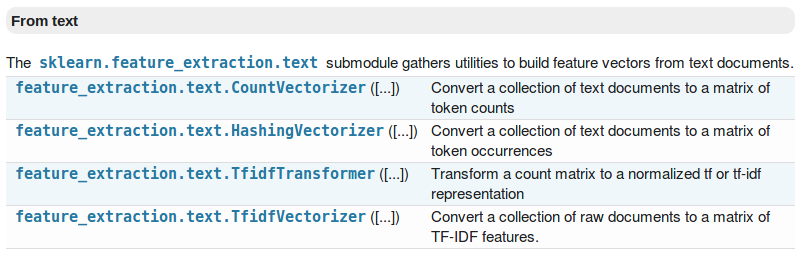

In [15]:
from IPython.display import Image
Image('skLearn_textExtraction.png')

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(tokenizer=tokenizeText, ngram_range=(1,1))   
# (containing the SpacY tokenizer tokenizeText)

## Put the cleaner and vectorizer in a pipeline and fit

In [10]:
# the pipeline to clean, tokenize, vectorize, and classify
pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])

In [11]:
p = pipe.fit_transform(documents)   # takes 20 min with ~10 textbooks!

## Apply the transformation to the term document matrix to compute similarity between all pairs

In [14]:
pairwise_similarity = (p * p.T).A #  In Scipy, .A transforms a sparse matrix to a dense one

### Just the textbooks

In [16]:
row_labels = list(TextBooksDict)
column_labels = list(TextBooksDict)
df8 = pd.DataFrame(pairwise_similarity, columns=column_labels, index=row_labels)
df8

,sheep.txt,Corporate Finance.txt,Excel2010Advanced.txt,distributedAI.txt,BrianYarvinPloughmansLunch.txt,HeatingCoolingPower.txt,louisianaBeefCattle.txt,datastyle.txt,TheDomesticCat.txt,catalog_chptech_full.txt,...,Excel2007VBA.txt,chp_handbook.txt,ElectricPowerGeneration.txt,ChemicalProcessDesign.txt,EnergyOptimization.txt,InternalCombustionEngines.txt,ISLR Sixth Printing.txt,machineLearning_chapmanHall.txt,Ensemble methods - Zhou.txt,huntingDogs.txt
sheep.txt,1.000000,0.118889,0.064609,0.055934,0.104999,0.120144,0.239089,0.094077,0.202857,0.062862,...,0.072716,0.065273,0.097066,0.099657,0.086091,0.065720,0.084483,0.076807,0.052239,0.144027
Corporate Finance.txt,0.118889,1.000000,0.114898,0.099890,0.075718,0.221237,0.115969,0.165273,0.064130,0.138106,...,0.135175,0.220518,0.168326,0.179128,0.161606,0.096441,0.193223,0.204695,0.106169,0.051117
Excel2010Advanced.txt,0.064609,0.114898,1.000000,0.066057,0.054513,0.113204,0.054185,0.232599,0.059764,0.078587,...,0.414843,0.089051,0.121717,0.115924,0.089112,0.051804,0.163731,0.141170,0.087242,0.034417
distributedAI.txt,0.055934,0.099890,0.066057,1.000000,0.047680,0.088455,0.043081,0.102773,0.034550,0.049730,...,0.096434,0.057495,0.102082,0.121222,0.181133,0.044137,0.153316,0.185849,0.148157,0.030636
BrianYarvinPloughmansLunch.txt,0.104999,0.075718,0.054513,0.047680,1.000000,0.089352,0.043514,0.070203,0.081444,0.062263,...,0.052092,0.042498,0.074363,0.116292,0.078864,0.055027,0.087058,0.107783,0.055430,0.051381
HeatingCoolingPower.txt,0.120144,0.221237,0.113204,0.088455,0.089352,1.000000,0.091752,0.186276,0.060087,0.737428,...,0.128964,0.362375,0.425159,0.508705,0.365875,0.490860,0.165141,0.155664,0.107497,0.047457
louisianaBeefCattle.txt,0.239089,0.115969,0.054185,0.043081,0.043514,0.091752,1.000000,0.059451,0.192703,0.043347,...,0.062107,0.104764,0.064962,0.051946,0.057141,0.033991,0.051501,0.044173,0.035193,0.131337
datastyle.txt,0.094077,0.165273,0.232599,0.102773,0.070203,0.186276,0.059451,1.000000,0.073522,0.091361,...,0.194100,0.170341,0.197789,0.208692,0.169089,0.081033,0.401982,0.314171,0.207875,0.060122
TheDomesticCat.txt,0.202857,0.064130,0.059764,0.034550,0.081444,0.060087,0.192703,0.073522,1.000000,0.031956,...,0.060952,0.042370,0.056034,0.049110,0.040169,0.033896,0.055219,0.051027,0.032306,0.195906
catalog_chptech_full.txt,0.062862,0.138106,0.078587,0.049730,0.062263,0.737428,0.043347,0.091361,0.031956,1.000000,...,0.075397,0.412718,0.254012,0.392683,0.250572,0.556382,0.102397,0.098234,0.063517,0.024092


### Just the captions

In [190]:
row_labels = list(ManyCaptionsDict)
column_labels = list(ManyCaptionsDict)
df7 = pd.DataFrame(pairwise_similarity, columns=column_labels, index=row_labels)
df7

,ALL ABOUT LIVING WITH BOXER DOGS,Lulu the Lab - Basic dog training in Austin (512) 927-9443,PetSmart Puppy Training: Feeding a Puppy,6. Reconstruction from Compressed Representation,Unit 6 8 Supervised vs Unsupervised Learning,"How To Socialise An Older Cat, 5 tips! PLUS: COMPETITION!",Smart and Funny Maine Coon Cat Leo Patents His Invention - Cat Toy using Drill Tutorial,My Cats Review the Licki Brush,Crispy Spicy Fried Cauliflower - Frittierte knusprige Blumenkohl - vegetarisch - Arabisch Kochen,Feuerwehrfrau kocht kinderleichten Nudelauflauf,• Kochen bei Freunden (Vlog) • (Ep. 16)
ALL ABOUT LIVING WITH BOXER DOGS,1.000000,0.206230,0.400635,0.415063,0.403052,0.526656,0.263763,0.396516,0.401278,0.550045,0.505729
Lulu the Lab - Basic dog training in Austin (512) 927-9443,0.206230,1.000000,0.094956,0.083347,0.084799,0.139825,0.093316,0.080131,0.099867,0.164508,0.092267
PetSmart Puppy Training: Feeding a Puppy,0.400635,0.094956,1.000000,0.308580,0.256318,0.260084,0.191296,0.318935,0.194033,0.353840,0.345376
6. Reconstruction from Compressed Representation,0.415063,0.083347,0.308580,1.000000,0.320386,0.346329,0.198695,0.267160,0.237379,0.409136,0.355258
Unit 6 8 Supervised vs Unsupervised Learning,0.403052,0.084799,0.256318,0.320386,1.000000,0.294994,0.161468,0.228932,0.241767,0.324468,0.278162
"How To Socialise An Older Cat, 5 tips! PLUS: COMPETITION!",0.526656,0.139825,0.260084,0.346329,0.294994,1.000000,0.240824,0.358595,0.251076,0.386710,0.367840
Smart and Funny Maine Coon Cat Leo Patents His Invention - Cat Toy using Drill Tutorial,0.263763,0.093316,0.191296,0.198695,0.161468,0.240824,1.000000,0.211830,0.185645,0.252001,0.243343
My Cats Review the Licki Brush,0.396516,0.080131,0.318935,0.267160,0.228932,0.358595,0.211830,1.000000,0.232414,0.343688,0.318141
Crispy Spicy Fried Cauliflower - Frittierte knusprige Blumenkohl - vegetarisch - Arabisch Kochen,0.401278,0.099867,0.194033,0.237379,0.241767,0.251076,0.185645,0.232414,1.000000,0.343841,0.269855
Feuerwehrfrau kocht kinderleichten Nudelauflauf,0.550045,0.164508,0.353840,0.409136,0.324468,0.386710,0.252001,0.343688,0.343841,1.000000,0.506895


In [ ]:
import numpy as np # save the 15 minutesfromlasttime
np.save('pairwise_similarity_24texts', pairwise_similarity)   
np.save('24textLabels', row_labels) 

In [ ]:
print("----------------------------------------------------------------------------------------------")
print("The original data as it appeared to the classifier after tokenizing, lemmatizing, stoplisting, etc")
# let's see what the pipeline was transforming the data into
#pipe = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer)])
transform = p # pipe.fit_transform(documents) # pipe.fit_transform(train, labelsTrain)

# get the features that the vectorizer learned (its vocabulary)
vocab = vectorizer.get_feature_names()

# the values from the vectorizer transformed data (each item is a row,column index with value as # times occuring in the sample, stored as a sparse matrix)
for i in range(len(documents)):
    s = ""
    indexIntoVocab = transform.indices[transform.indptr[i]:transform.indptr[i+1]]
    numOccurences = transform.data[transform.indptr[i]:transform.indptr[i+1]]
    for idx, num in zip(indexIntoVocab, numOccurences):
        s += str((vocab[idx], num))
    print("Sample {}: {}".format(i, s))